# Enter Home / Away Teams and League

In [2]:
home_team = 'FC Tokyo'
away_team = 'Cerezo Osaka'
league = 'japan' #write with small letter
last_matches = 5

# Scrape League Statistics for those teams

In [3]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

final =  pd.DataFrame()
next_matches = pd.DataFrame()

URL = "https://www.soccerstats.com/results.asp?league=" + league + "&pmtype=bydate"
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")
results = soup.find(id="btable")
sth = results.find_all("tr", class_="odd")

date, liqa, home, away, ft, ht = [], [], [], [], [],[]

for row in sth:
    try:
        tds_right = row.find_all("td", align='right')
        tds_center = row.find_all("td", align='center')
        
        date.append(tds_right[0].get_text(strip=True))
        liqa.append(league.capitalize())
        home.append(tds_right[1].get_text(strip=True))
        away.append(row.find("td", align="left").get_text(strip=True))
        ft.append(tds_center[0].get_text(strip=True))
        
        try:
            ht.append(tds_center[2].get_text(strip=True))
        except IndexError:
            ht.append('NA')
    
    except Exception as e:
        print("Error processing row:", e)
        continue

data = {'Date': date, 'League': liqa,'Home': home, 'Away': away, 'FT': ft, 'HT': ht}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Replace empty strings with NaN
next_df = df[df['HT'] == '']
next_matches = pd.concat([next_matches, next_df], ignore_index = True)
df.replace('', pd.NA, inplace=True)

# Drop rows with NaN values
df_cleaned = df.dropna()

#For Half-Time Results
hthg, htag = [], []
for i in df_cleaned['HT']:
    if i == 'NA':
        hthg.append('NA')
        htag.append('NA')
    elif i == '+' or i == '-':
        hthg.append('NA')
        htag.append('NA')
    else:
        try:
            hthg.append(int(i[1]))
            htag.append(int(i[3]))
        except IndexError as e:
            print("Last output before error occurred:", i)



#For Full-Time Results
hg, ag, tg = [], [], []
for i in df_cleaned['FT']:
    if len(i) < 5 or ':' in i:
        hg.append('NA')
        ag.append('NA')
        tg.append('NA')
    else:
        try:
            hghg = int(i.split(' - ')[0])
            hg.append(hghg)
            agag = int(i.split(' - ')[1])
            ag.append(agag)
            tg.append(hghg + agag)
        except:
            print(hghg + agag)

    
df_cleaned['FTHG'], df_cleaned['FTAG'], df_cleaned['FTTG'] = hg, ag, tg
df_cleaned['HTHG'], df_cleaned['HTAG'] = hthg, htag
df_cleaned['HTTG'] = df_cleaned['HTHG'] + df_cleaned['HTAG']

final = pd.concat([final, df_cleaned], ignore_index=True)
    
final = final[final['HT'] != 'NA']

# Home points
final['HPTS'] = np.where(final['FTHG'] > final['FTAG'], 3,
                        np.where(final['FTHG'] < final['FTAG'], 0, 1))

# Away points (just reverse the logic)
final['APTS'] = np.where(final['FTAG'] > final['FTHG'], 3,
                        np.where(final['FTAG'] < final['FTHG'], 0, 1))


final.tail()

,Date,League,Home,Away,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG,HPTS,APTS
184,Sa 31 May,Japan,Gamba Osaka,Kashima Antlers,0 - 1,(0-1),0,1,1,0,1,1,0,3
185,Sa 31 May,Japan,Kyoto Sanga,FC Tokyo,3 - 0,(1-0),3,0,3,1,0,1,3,0
186,Su 1 Jun,Japan,Cerezo Osaka,Shimizu S-Pulse,4 - 2,(2-1),4,2,6,2,1,3,3,0
187,Su 1 Jun,Japan,Shonan Bellmare,Fagiano Okayama,1 - 1,(0-1),1,1,2,0,1,1,1,1
188,Su 1 Jun,Japan,Urawa RD,Yokohama FC,2 - 1,(0-1),2,1,3,0,1,1,3,0


# Taking relevant statistics for Home/Away Teams and Visualizing

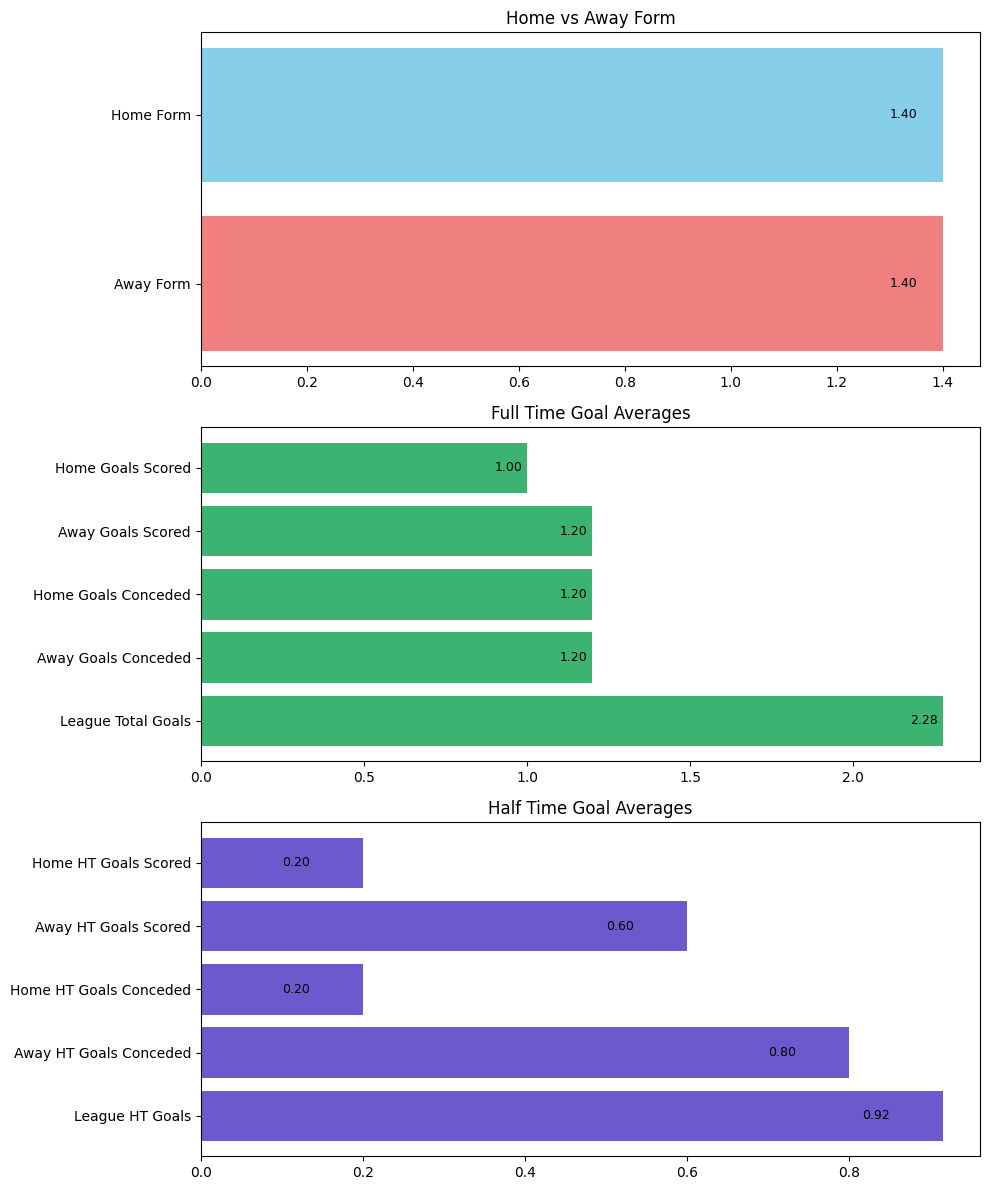

In [13]:
import matplotlib.pyplot as plt

home_df = final[final['Home'] == home_team].tail(last_matches)
away_df = final[final['Away'] == away_team].tail(last_matches)

# ----- Visual 1: Home Form & Away Form -----
home_form = round(home_df['HPTS'].sum() / len(home_df), 2)
away_form = round(away_df['APTS'].sum() / len(away_df), 2)

form_labels = ['Home Form', 'Away Form']
form_values = [home_form, away_form]

# ----- Visual 2: Full Time Averages -----
full_time_labels = ['Home Goals Scored', 'Away Goals Scored', 
                    'Home Goals Conceded', 'Away Goals Conceded', 'League Total Goals']
full_time_values = [
    home_df['FTHG'].mean(),
    away_df['FTAG'].mean(),
    home_df['FTAG'].mean(),  # Home Conceded = Away Scored
    away_df['FTHG'].mean(),  # Away Conceded = Home Scored
    final['FTTG'].mean()
]

# ----- Visual 3: Half Time Averages -----
half_time_labels = ['Home HT Goals Scored', 'Away HT Goals Scored','Home HT Goals Conceded', 'Away HT Goals Conceded', 'League HT Goals']
half_time_values = [
    home_df['HTHG'].mean(),
    away_df['HTAG'].mean(),
    home_df['HTAG'].mean(),
    away_df['HTHG'].mean(),
    final['HTTG'].mean()
]

# ----- Plotting -----
fig, axs = plt.subplots(3, 1, figsize=(10, 12))  # 3 rows, 1 column

# Helper function to label bars
def add_labels(ax, bars):
    for bar in bars:
        width = bar.get_width()
        ax.text(width - 0.1, bar.get_y() + bar.get_height()/2,
                f'{width:.2f}', va='center', fontsize=9)

# Plot 1: Form
bars1 = axs[0].barh(form_labels, form_values, color=['skyblue', 'lightcoral'])
axs[0].set_title('Home vs Away Form')
axs[0].invert_yaxis() 
add_labels(axs[0], bars1)

# Plot 2: Full Time Averages
bars2 = axs[1].barh(full_time_labels, full_time_values, color='mediumseagreen')
axs[1].set_title('Full Time Goal Averages')
axs[1].invert_yaxis() 
add_labels(axs[1], bars2)

# Plot 3: Half Time Averages
bars3 = axs[2].barh(half_time_labels, half_time_values, color='slateblue')
axs[2].set_title('Half Time Goal Averages')
axs[2].invert_yaxis() 
add_labels(axs[2], bars3)

# Tight layout and show
plt.tight_layout()
plt.show()


In [6]:
home_df

,Date,League,Home,Away,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG,HPTS,APTS
89,Fr 11 Apr,Japan,FC Tokyo,Kashiwa Reysol,1 - 1,(1-0),1,1,2,1,0,1,1,1
117,Fr 25 Apr,Japan,FC Tokyo,Gamba Osaka,3 - 0,(0-0),3,0,3,0,0,0,3,0
120,Tu 29 Apr,Japan,FC Tokyo,Shimizu S-Pulse,0 - 2,(0-1),0,2,2,0,1,1,0,3
145,Sa 10 May,Japan,FC Tokyo,Vissel Kobe,1 - 0,(0-0),1,0,1,0,0,0,3,0
175,Su 25 May,Japan,FC Tokyo,S. Hiroshima,0 - 3,(0-0),0,3,3,0,0,0,0,3


In [7]:
away_df

,Date,League,Home,Away,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG,HPTS,APTS
116,Fr 25 Apr,Japan,Tokyo Verdy,Cerezo Osaka,1 - 0,(1-0),1,0,1,1,0,1,3,0
135,Sa 3 May,Japan,Kyoto Sanga,Cerezo Osaka,2 - 3,(2-2),2,3,5,2,2,4,0,3
138,Tu 6 May,Japan,Vissel Kobe,Cerezo Osaka,1 - 3,(1-1),1,3,4,1,1,2,0,3
165,Su 18 May,Japan,K. Frontale,Cerezo Osaka,2 - 0,(0-0),2,0,2,0,0,0,3,0
178,We 28 May,Japan,Urawa RD,Cerezo Osaka,0 - 0,(0-0),0,0,0,0,0,0,1,1
